In [1]:
# Imports you'll need.
from collections import Counter
import ConfigParser
import matplotlib.pyplot as plt
import sys
import time
from TwitterAPI import TwitterAPI
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
# This method is done for you. Make sure to put your credentials in twitter.cfg.
def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
print('Established Twitter connection.')

Established Twitter connection.


In [3]:
#for i in range(0, 16): ## iterate through 16 times to get max No. of tweets

def fatch_available_tweets_investor(screen_name):
    from datetime import datetime
    investor_tweet = {}
        
    b = []    
    for i in range(0, 16):
        if i ==0:
            request = twitter.request('statuses/user_timeline', {'screen_name': screen_name, 'count': '200' })
        else:
            request = twitter.request('statuses/user_timeline', {'screen_name': screen_name, 'count': '200', 'max_id' : b[-1]})
        if request.status_code == 200:
            for tweet in request:
                created_at = datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S +0000 %Y')
                created_at = str( created_at )
                investor_tweet[created_at] = tweet['text']
                b.append(tweet['id']) ## append tweet id's
        elif request.status_code == 88:
            continue
        else:
            print screen_name
            print >> sys.stderr, 'Got error:\n', request.text, '\nsleeping for 15 minutes.'
            sys.stderr.flush()
            time.sleep(61 * 15)
        
    return investor_tweet

In [4]:
def merge_dicts(list_of_dictionary):
    '''
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in list_of_dictionary:
        result.update(dictionary)
    return result

In [5]:
# NOTE: Do not run this block, this is fatching all tweeter data, this will take more then an hour
#       We have already downloaded data, go down and run the block as suggested to load all data in next to next block 


#faatch tweets from users given in "input.txt"
#and generate "data.txt" file with all tweets 
#in jason formate like 'created date-time' -> 'tweet text'
#also returns a complete 

result = []
fopen = open("input.txt")
fopen.seek(0)
for line in fopen:
    tuples = fatch_available_tweets_investor(line)
    result.append(tuples)

Got error:
{"errors":[{"message":"Rate limit exceeded","code":88}]} 
sleeping for 15 minutes.


gregorymckenna

Benzinga


Got error:
{"errors":[{"message":"Rate limit exceeded","code":88}]} 
sleeping for 15 minutes.



TheStreet


Got error:
{"errors":[{"message":"Rate limit exceeded","code":88}]} 
sleeping for 15 minutes.



vkhosla


Got error:
{"errors":[{"message":"Rate limit exceeded","code":88}]} 
sleeping for 15 minutes.


In [6]:
#merge all tweets from all investors in one single object
all_tweets = merge_dicts(result)

In [ ]:
#Sorts all tweet in chronological order
#Again
# NOTE: Do not run this block, We have already done this part and stored data pickle, run next block instead 

print len(all_tweets)
sorted_all_tweets = sorted(all_tweets.items(), key=operator.itemgetter(0))



In [6]:
#Just run this code for loading all tweets
import pickle
# We dumped all data by this command
#pickle.dump(sorted_all_tweets, open( "sorted_all_tweets.p", "wb" ))

sorted_all_tweets = pickle.load(open('sorted_all_tweets.p', 'rb'))




In [7]:
#sample of sorted tweets/testing data
print sorted_all_tweets[5]

('2009-02-14 22:52:30', u'Researching a company for potential investment.')


In [19]:
#store all data in json formate as well, in data.txt
import json
outf = open('data.txt', 'wt')
json.dump(sorted_all_tweets , outf, indent=4)
outf.close()

In [8]:
import re
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation, special characters and numbers are removed. Only alphabates are considered
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    ###
    text = text.lower()
    tokens = re.sub('[^a-zA-Z]', ' ', text).split()
    return tokens

In [9]:
#How our tokenize function works
tokenize("my name is tirth 1234 5:4 @%^*&%#^&gk mayank? !")

['my', 'name', 'is', 'tirth', 'gk', 'mayank']

In [10]:
# Exploring and doing Proof of concepts by taking 2010 data

#tweets_2009 = [(key,value) for key, value in sorted_all_tweets if key > '2009-01-01' and key < '2009-12-12']
tweets_2010 = [(key,value) for key, value in sorted_all_tweets if key > '2010-01-01' and key < '2010-12-31']

# Create feature vectors (X)
from sklearn.feature_extraction.text import CountVectorizer
#after few itterations and trial and error, we decided to keep min_df=2, max_df = 7 for better results
vectorizer = CountVectorizer(tokenizer=tokenize, min_df=2, max_df = 7)
X = vectorizer.fit_transform(t[1] for t in tweets_2010)
print 'vectorized %d tweets. found %d terms.' % (X.shape[0], X.shape[1])

vectorized 2284 tweets. found 1880 terms.


In [11]:
# What are the most frequent terms in our sample tweets_2010?
import numpy as np
# Sum columns:
col_sums = X.sum(axis=0).tolist()[0]
# Sort sums in descending order, and return the indices.
top_indices = np.argsort(col_sums)[::-1]
print 'top_indices=', top_indices
vocab = np.array(vectorizer.get_feature_names())
top_terms = vocab[top_indices]
print 'top_terms:\n', '\n'.join('%s %d' % (term, count) for term, count in zip(top_terms, top_indices)[:20])

top_indices= [1743  745 1799 ...,  630  629  939]
top_terms:
unicef 1743
google 745
wall 1799
might 1089
being 162
pricing 1313
process 1319
haiti 774
without 1834
information 878
before 156
uk 1733
trying 1722
hk 814
mateo 1059
ready 1372
email 523
both 199
elite 519
nasdaq 1143


In [12]:
#Creating Training dataset from our industryList.txt file

industryDictionary = {}
fopen = open('industryList.txt')
fopen.seek(0)
for line in fopen:
    industryDetails = tokenize(line)
    industryDictionary[industryDetails[0]] = industryDetails

industryDictionary



{'agribusiness': ['agribusiness',
  'crop',
  'production',
  'basic',
  'processing',
  'vegetables',
  'fruits',
  'sugar',
  'cane',
  'sugar',
  'beets',
  'tobacco',
  'dairy',
  'poultry',
  'eggs',
  'livestock',
  'agricultural',
  'services',
  'products',
  'farm',
  'bureaus',
  'food',
  'processing',
  'sales',
  'food',
  'products',
  'manufacturing',
  'food',
  'stores',
  'meat',
  'processing',
  'products',
  'forestry',
  'forest',
  'products'],
 'communicationsandelectronics': ['communicationsandelectronics',
  'printing',
  'publishing',
  'books',
  'magazines',
  'newspapers',
  'tv',
  'movies',
  'music',
  'cable',
  'satellite',
  'tv',
  'production',
  'distribution',
  'commercial',
  'tv',
  'radio',
  'stations',
  'motion',
  'picture',
  'production',
  'distribution',
  'recorded',
  'music',
  'music',
  'production',
  'tv',
  'production',
  'telephone',
  'utilities',
  'telecom',
  'services',
  'equipment',
  'electronics',
  'manufacturing',

In [13]:
X

<2284x1880 sparse matrix of type '<type 'numpy.int64'>'
	with 6045 stored elements in Compressed Sparse Row format>

In [14]:
#Proof of concepts of our Analizer by checking terms into our training dataset 
#and deciding which terms are frequent in tweets for our tweet_2010 

resultDirectory = {} 
for i in range(X.get_shape()[0]):
        for j in range(X.get_shape()[1]):
            if X[i,j]>0:
                for k,v in industryDictionary.iteritems():
                        if  vocab[j] in v:
                            if k in resultDirectory:  
                                resultDirectory[k] = resultDirectory[k] + X[i,j]
                            else:
                                resultDirectory[k] = X[i,j]
resultDirectory

{'agribusiness': 11,
 'communicationsandelectronics': 25,
 'construction': 5,
 'defence': 3,
 'education': 33,
 'energyandnaturalresources': 10,
 'entertainment': 6,
 'finance': 23,
 'food': 3,
 'ideologicalandsingleissue': 34,
 'informationtechnology': 30,
 'labor': 26,
 'manufacturing': 9,
 'tourism': 11,
 'transportation': 8}

In [17]:
# function to create feature vectors (X) for tweets
'''
input: List of tweets
output: a sparce matrix and vocab of that matrix
'''

def createSparseMatrix(tweets):    
    vectorizer = CountVectorizer(tokenizer=tokenize, min_df=2, max_df = 7)
    X = vectorizer.fit_transform(t[1] for t in tweets)
    vocab = np.array(vectorizer.get_feature_names())
    return X, vocab

In [18]:
# Function to analyze input tweeter set and deciding poopular sectors of industry
'''
input:  X      - sparce mateix of tweets and terms
        vocab  - vocabulary of the sparce matrix
        industryDictionary - training dataset as directory of industry(key): related terms(values)
        
output: resultDirectory - output as directory of list of industry(key): popularity rank(value) #just considered occarance for now
'''

def calculatePopularSectors(X, vocab, industryDictionary):
    resultDirectory = {} 
    for i in range(X.get_shape()[0]):
            for j in range(X.get_shape()[1]):
                if X[i,j]>0:
                    for k,v in industryDictionary.iteritems():
                            if  vocab[j] in v:
                                if k in resultDirectory:  
                                    resultDirectory[k] = resultDirectory[k] + X[i,j]
                                else:
                                    resultDirectory[k] = X[i,j]
    return resultDirectory

In [ ]:
#NOTE: Do not run this block as it contains analysis of almost 100,000 tweets by comparing terms of each, 
#      It takes too much time. We have run this part and included in our presentation and report.
#      So, instead run the next block which takes random 3000 samples of each qarter and give us results     
#Final run for all quater wise analysis

def finalQuarterlyAnalysis(sorted_all_tweets,industryDictionary,startyear = 2015):
    resultDirectory = {}
    #for year in range(startyear,2016):
    tweets_Q1 = [(key,value) for key, value in sorted_all_tweets if key > str(startyear)+'-01-01' and key < str(startyear)+'-03-31']
    X1, vocab1 = createSparseMatrix(tweets_Q1)
    print 'Q1 tweets vectorized %d tweets. found %d terms.' % (X1.shape[0], X1.shape[1])
    Q1result = calculatePopularSectors(X1, vocab1, industryDictionary)
    resultDirectory['1stQuarter 2015'] = Q1result

    tweets_Q2 = [(key,value) for key, value in sorted_all_tweets if key > str(startyear)+'-04-01' and key < str(startyear)+'-06-30']
    X2, vocab2 = createSparseMatrix(tweets_Q2)
    print 'Q2 tweets vectorized %d tweets. found %d terms.' % (X2.shape[0], X2.shape[1])
    Q2result = calculatePopularSectors(X2, vocab2, industryDictionary)
    resultDirectory['2ndQuarter 2015'] = Q2result

    tweets_Q3 = [(key,value) for key, value in sorted_all_tweets if key > str(startyear)+'-07-01' and key < str(startyear)+'-09-30']
    X3, vocab3 = createSparseMatrix(tweets_Q3)
    print 'Q3 tweets vectorized %d tweets. found %d terms.' % (X3.shape[0], X3.shape[1])
    Q3result = calculatePopularSectors(X3, vocab3, industryDictionary)
    resultDirectory['3rdQuarter 2015'] = Q3result

    tweets_Q4 = [(key,value) for key, value in sorted_all_tweets if key > str(startyear)+'-10-01' and key < str(startyear)+'-12-31']
    X4, vocab4 = createSparseMatrix(tweets_Q4)
    print 'Q1 tweets vectorized %d tweets. found %d terms.' % (X4.shape[0], X4.shape[1])
    Q4result = calculatePopularSectors(X4, vocab4, industryDictionary)
    resultDirectory['4thQuarter 2015'] = Q4result
    
    return resultDirectory
        
resultDirectory = finalQuarterlyAnalysis(sorted_all_tweets,industryDictionary,startyear = 2015)

resultDirectory

In [19]:
# Taking random samples from each quarter and calculating with our analysier to get most popular sectors in investors

import random

def finalQuarterlyAnalysis(sorted_all_tweets,industryDictionary,startyear = 2015):
    resultDirectory = {}
    #for year in range(startyear,2016):
    tweets_Q1 = [(key,value) for key, value in sorted_all_tweets if key > str(startyear)+'-01-01' and key < str(startyear)+'-03-31']
    random.shuffle(tweets_Q1)
    tweets_Q1 = tweets_Q1[0:3000]
    #print tweets_Q1
    X1, vocab1 = createSparseMatrix(tweets_Q1)
    print 'Q1 tweets vectorized %d tweets. found %d terms.' % (X1.shape[0], X1.shape[1])
    Q1result = calculatePopularSectors(X1, vocab1, industryDictionary)
    resultDirectory['1stQuarter 2015'] = Q1result
    
    tweets_Q2 = [(key,value) for key, value in sorted_all_tweets if key > str(startyear)+'-04-01' and key < str(startyear)+'-06-30']
    random.shuffle(tweets_Q2)
    tweets_Q2 = tweets_Q2[0:3000]
    X2, vocab2 = createSparseMatrix(tweets_Q2)
    print 'Q2 tweets vectorized %d tweets. found %d terms.' % (X2.shape[0], X2.shape[1])
    Q2result = calculatePopularSectors(X2, vocab2, industryDictionary)
    resultDirectory['2ndQuarter 2015'] = Q2result

    tweets_Q3 = [(key,value) for key, value in sorted_all_tweets if key > str(startyear)+'-07-01' and key < str(startyear)+'-09-30']
    random.shuffle(tweets_Q3)
    tweets_Q3 = tweets_Q3[0:3000]
    X3, vocab3 = createSparseMatrix(tweets_Q3)
    print 'Q3 tweets vectorized %d tweets. found %d terms.' % (X3.shape[0], X3.shape[1])
    Q3result = calculatePopularSectors(X3, vocab3, industryDictionary)
    resultDirectory['3rdQuarter 2015'] = Q3result

    tweets_Q4 = [(key,value) for key, value in sorted_all_tweets if key > str(startyear)+'-10-01' and key < str(startyear)+'-12-31']
    random.shuffle(tweets_Q4)
    tweets_Q4 = tweets_Q4[0:3000]
    X4, vocab4 = createSparseMatrix(tweets_Q4)
    print 'Q1 tweets vectorized %d tweets. found %d terms.' % (X4.shape[0], X4.shape[1])
    Q4result = calculatePopularSectors(X4, vocab4, industryDictionary)
    resultDirectory['4thQuarter 2015'] = Q4result

    
    
    return resultDirectory
        
resultDirectory = finalQuarterlyAnalysis(sorted_all_tweets,industryDictionary,startyear = 2015)

resultDirectory

Q1 tweets vectorized 500 tweets. found 646 terms.
Q2 tweets vectorized 500 tweets. found 643 terms.
Q3 tweets vectorized 500 tweets. found 657 terms.
Q1 tweets vectorized 500 tweets. found 670 terms.


{'1stQuarter 2015': {'agribusiness': 2,
  'communicationsandelectronics': 4,
  'education': 14,
  'energyandnaturalresources': 9,
  'entertainment': 2,
  'finance': 33,
  'food': 2,
  'health': 5,
  'ideologicalandsingleissue': 7,
  'informationtechnology': 22,
  'labor': 13,
  'manufacturing': 2,
  'transportation': 2},
 '2ndQuarter 2015': {'agribusiness': 18,
  'communicationsandelectronics': 11,
  'construction': 2,
  'education': 21,
  'entertainment': 6,
  'finance': 27,
  'food': 3,
  'health': 3,
  'ideologicalandsingleissue': 12,
  'informationtechnology': 23,
  'labor': 5,
  'manufacturing': 10,
  'tourism': 3,
  'transportation': 4},
 '3rdQuarter 2015': {'agribusiness': 3,
  'communicationsandelectronics': 5,
  'education': 9,
  'energyandnaturalresources': 6,
  'entertainment': 3,
  'finance': 22,
  'food': 2,
  'ideologicalandsingleissue': 6,
  'informationtechnology': 20,
  'labor': 9},
 '4thQuarter 2015': {'agribusiness': 10,
  'communicationsandelectronics': 9,
  'constr

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

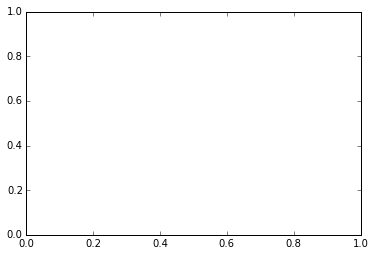

In [20]:
industry = []
trend = []
for items in resultDirectory:
    industry.append(items)
    trend.append(resultDirectory[items])

x = np.arange(len(resultDirectory))

plt.bar(x, trend)
chart = plt.xticks(x + 0.5, [item.capitalize() for item in industry],  rotation= 90)